# Evaluating Classical and Modern Forecasting Techniques for Hourly Air Temperature Predictions

**INTRODUCTION**

Accurate short-term temperature forecasting is essential for environmental monitoring, energy management, and daily operational planning. With the growing availability of high-resolution weather data, both classical statistical models and modern machine-learning techniques are widely used to predict temperature trends.

This project compares several forecasting approaches namelyy Naive, Seasonal-Naive, Mean, SARIMA, Random Forest, and LSTM; using one year of hourly temperature data. The goal is to evaluate how traditional time-series methods perform relative to machine-learning and deep-learning models in predicting hourly air temperature. By analysing their accuracy across a common test period, the study identifies which modelling approach offers the most reliable performance for short-term temperature forecasting.

In [ ]:
#required packages
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
#loading the dataset
df = pd.read_csv('cleaned_weather.csv')
df

,date,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,...,rho,wv,max. wv,wd,rain,raining,SWDR,PAR,max. PAR,Tlog
0,2020-01-01 00:10:00,1008.89,0.71,273.18,-1.33,86.1,6.43,5.54,0.89,3.42,...,1280.62,1.02,1.60,224.3,0.0,0.0,0.0,0.0,0.0,11.45
1,2020-01-01 00:20:00,1008.76,0.75,273.22,-1.44,85.2,6.45,5.49,0.95,3.39,...,1280.33,0.43,0.84,206.8,0.0,0.0,0.0,0.0,0.0,11.51
2,2020-01-01 00:30:00,1008.66,0.73,273.21,-1.48,85.1,6.44,5.48,0.96,3.39,...,1280.29,0.61,1.48,197.1,0.0,0.0,0.0,0.0,0.0,11.60
3,2020-01-01 00:40:00,1008.64,0.37,272.86,-1.64,86.3,6.27,5.41,0.86,3.35,...,1281.97,1.11,1.48,206.4,0.0,0.0,0.0,0.0,0.0,11.70
4,2020-01-01 00:50:00,1008.61,0.33,272.82,-1.50,87.4,6.26,5.47,0.79,3.38,...,1282.08,0.49,1.40,209.6,0.0,0.0,0.0,0.0,0.0,11.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52691,2020-12-31 23:20:00,978.32,2.28,277.16,-0.80,80.0,7.20,5.76,1.44,3.67,...,1234.61,0.73,1.40,180.6,0.0,0.0,0.0,0.0,0.0,13.40
52692,2020-12-31 23:30:00,978.30,2.13,277.01,-0.43,83.1,7.12,5.92,1.20,3.77,...,1235.20,0.43,0.82,174.0,0.0,0.0,0.0,0.0,0.0,13.42
52693,2020-12-31 23:40:00,978.26,1.99,276.88,-0.71,82.2,7.05,5.80,1.26,3.69,...,1235.82,0.38,0.76,248.9,0.0,0.0,0.0,0.0,0.0,13.45
52694,2020-12-31 23:50:00,978.26,2.07,276.95,-0.77,81.4,7.09,5.77,1.32,3.68,...,1235.49,0.57,1.07,196.6,0.0,0.0,0.0,0.0,0.0,13.47


In [ ]:
#parse datetime
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

df.head()

,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,rho,wv,max. wv,wd,rain,raining,SWDR,PAR,max. PAR,Tlog
date,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:10:00,1008.89,0.71,273.18,-1.33,86.1,6.43,5.54,0.89,3.42,5.49,1280.62,1.02,1.60,224.3,0.0,0.0,0.0,0.0,0.0,11.45
2020-01-01 00:20:00,1008.76,0.75,273.22,-1.44,85.2,6.45,5.49,0.95,3.39,5.45,1280.33,0.43,0.84,206.8,0.0,0.0,0.0,0.0,0.0,11.51
2020-01-01 00:30:00,1008.66,0.73,273.21,-1.48,85.1,6.44,5.48,0.96,3.39,5.43,1280.29,0.61,1.48,197.1,0.0,0.0,0.0,0.0,0.0,11.60
2020-01-01 00:40:00,1008.64,0.37,272.86,-1.64,86.3,6.27,5.41,0.86,3.35,5.37,1281.97,1.11,1.48,206.4,0.0,0.0,0.0,0.0,0.0,11.70
2020-01-01 00:50:00,1008.61,0.33,272.82,-1.50,87.4,6.26,5.47,0.79,3.38,5.42,1282.08,0.49,1.40,209.6,0.0,0.0,0.0,0.0,0.0,11.81


## Data Exploration

In [ ]:
#data shape
print("Number of Rows:", df.shape[0])
print("Number of Columns:", df.shape[1])

Number of Rows: 52696
Number of Columns: 20


In [ ]:
#check the time horizon
start, end = df.index.min(), df.index.max()
print("Time range:", start, "to", end)

Time range: 2020-01-01 00:10:00 to 2021-01-01 00:00:00


In [ ]:
#check for missing values
df.isna().sum()

,0
p,0
T,0
Tpot,0
Tdew,0
rh,0
VPmax,0
VPact,0
VPdef,0
sh,0
H2OC,0


In [ ]:
#explore the statistical description of the dataset
df.describe()

,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,rho,wv,max. wv,wd,rain,raining,SWDR,PAR,max. PAR,Tlog
count,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000
mean,989.989233,10.818241,284.796938,5.409105,72.487133,14.487046,9.676828,4.810131,6.111159,9.782341,1210.882855,1.995935,3.632807,176.850276,0.011773,25.907469,131.331822,259.863438,308.601939,21.515206
std,9.207149,7.468671,7.616995,5.956722,19.230260,7.632960,4.023504,5.539320,2.561536,4.082684,36.430222,43.596931,2.462467,81.194840,0.123289,111.503420,215.735116,422.786515,569.956762,7.790620
min,955.580000,-6.440000,266.190000,-13.810000,21.160000,3.770000,2.090000,0.000000,1.300000,2.090000,1107.380000,-9999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9999.000000,6.900000
25%,984.800000,4.590000,278.550000,0.777500,58.820000,8.480000,6.460000,1.170000,4.070000,6.530000,1183.900000,1.000000,1.770000,141.100000,0.000000,0.000000,0.000000,0.000000,0.000000,15.240000
50%,990.920000,10.230000,284.320000,5.260000,75.400000,12.480000,8.890000,2.740000,5.610000,8.990000,1210.800000,1.770000,3.000000,195.500000,0.000000,0.000000,2.820000,9.670000,13.120000,20.440000
75%,995.930000,16.180000,290.260000,9.700000,87.900000,18.420000,12.050000,6.440000,7.620000,12.200000,1236.550000,2.920000,4.850000,226.700000,0.000000,0.000000,182.900000,366.437500,434.260000,26.822500
max,1020.070000,34.800000,309.130000,20.500000,100.000000,55.670000,24.160000,42.100000,15.400000,24.530000,1318.520000,13.770000,22.900000,360.000000,11.200000,600.000000,1115.290000,2131.760000,2498.940000,49.090000


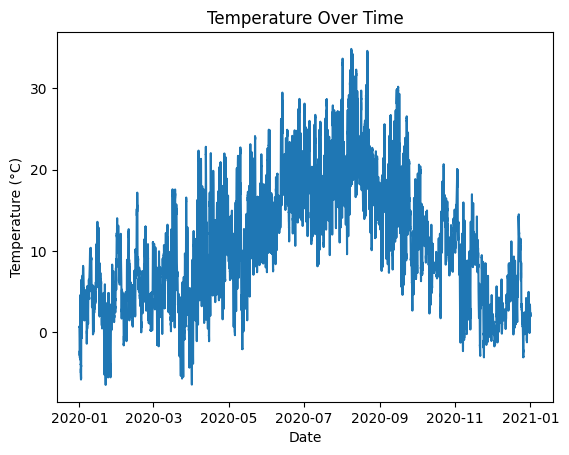

In [ ]:
#plot the temperature
plt.plot(df['T'])
plt.title("Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.show()


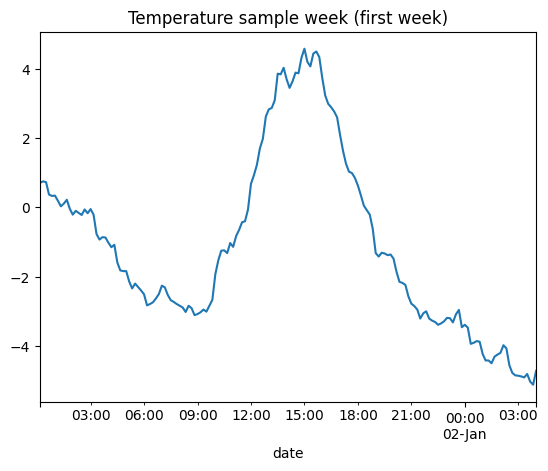

In [ ]:
#plotting one week data to inspect high-frequency behaviour
one_week = df['T'].iloc[:24*7]
one_week.plot(title="Temperature sample week (first week)")
plt.show()

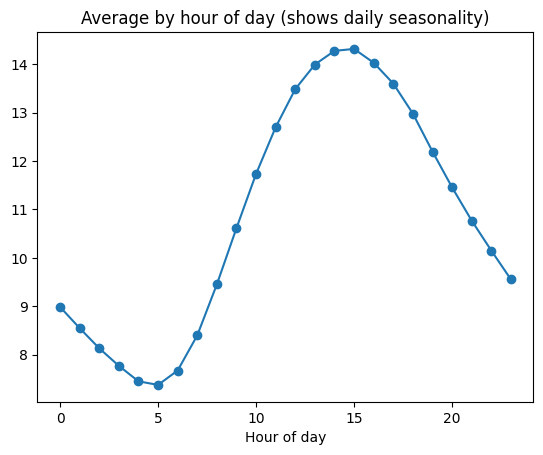

In [ ]:
#check daily seasonality
series_hourly = df.resample('h').mean()['T']
hourly_mean_by_hour = series_hourly.groupby(series_hourly.index.hour).mean()
hourly_mean_by_hour.plot(marker='o', title='Average by hour of day (shows daily seasonality)')
plt.xlabel('Hour of day')
plt.show()


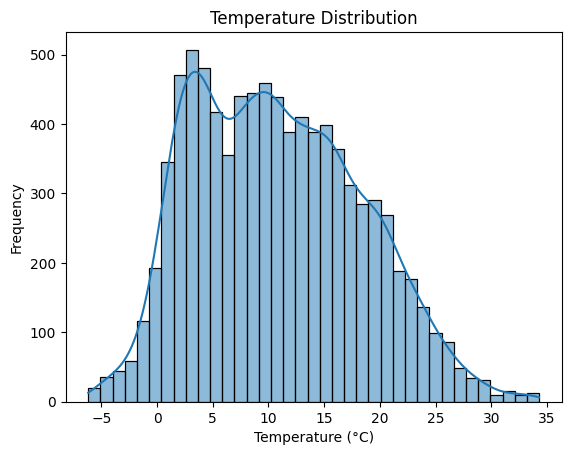

In [ ]:
df = df.resample('h').mean()
sns.histplot(df['T'], kde=True)
plt.title("Temperature Distribution")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
#simple outlier detection for target using IQR and cap extremes
q1 = df['T'].quantile(0.25)
q3 = df['T'].quantile(0.75)
iqr = q3 - q1
lower = q1 - 3 * iqr
upper = q3 + 3 * iqr
n_outliers = ((df['T'] < lower) | (df['T'] > upper)).sum()
print("Detected outliers (extreme 3*IQR):", n_outliers)

Detected outliers (extreme 3*IQR): 0


In [ ]:
df['hour'] = df.index.hour
df['dow'] = df.index.dayofweek
#create lags of target (1,24,168)
df['lag1'] = df['T'].shift(1)
df['lag24'] = df['T'].shift(24)
df['lag168'] = df['T'].shift(24*7)

In [ ]:
df.shape

(8785, 25)

In [ ]:
#drop first rows with NaNs due to lags
df = df.dropna()
print("After feature engineering, rows:", len(df))
df.head()

After feature engineering, rows: 8613


,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,...,raining,SWDR,PAR,max. PAR,Tlog,hour,dow,lag1,lag24,lag168
date,,,,,,,,,,,,,,,,,,,,,
2020-01-08 00:00:00,1000.626667,1.300000,274.411667,-0.048333,90.683333,6.711667,6.085000,0.625000,3.793333,6.083333,...,0.0,0.0,0.0,0.0,12.891667,0,2,1.671667,-0.520000,0.578000
2020-01-08 01:00:00,1000.415000,2.058333,275.183333,0.371667,88.566667,7.086667,6.275000,0.811667,3.913333,6.275000,...,0.0,0.0,0.0,0.0,12.665000,1,2,1.300000,-0.066667,0.141667
2020-01-08 02:00:00,1000.168333,3.360000,276.508333,0.818333,83.366667,7.780000,6.481667,1.296667,4.041667,6.480000,...,0.0,0.0,0.0,0.0,13.245000,2,2,2.058333,-0.061667,-0.153333
2020-01-08 03:00:00,999.678333,3.988333,277.170000,0.918333,80.333333,8.131667,6.530000,1.600000,4.073333,6.533333,...,0.0,0.0,0.0,0.0,14.045000,3,2,3.360000,0.265000,-0.615000
2020-01-08 04:00:00,998.810000,4.341667,277.596667,0.811667,77.733333,8.336667,6.478333,1.856667,4.045000,6.485000,...,0.0,0.0,0.0,0.0,14.628333,4,2,3.988333,0.783333,-1.416667


## Training Forecasting Models

**Prepare the dataset for training the forecast model**

In [ ]:
#force hourly frequency
df = df.asfreq('h')

#check for introduced missing rows, fill if any
df['T'] = df['T'].interpolate(method='time')

In [ ]:
#split the dataset
steps_per_day = 24
test_steps = 7 * steps_per_day

train_df = df.iloc[:-test_steps].copy()
test_df  = df.iloc[-test_steps:].copy()

train_y = train_df['T']
test_y  = test_df['T']

print("Train size:", len(train_df), "Test size:", len(test_df))
print("Train index frequency:", train_df.index.freq)


Train size: 8449 Test size: 168
Train index frequency: <Hour>


In [ ]:
#seed every outputs
np.random.seed(42)
tf.random.set_seed(42)

#create evaluation metrics functions
def mae(a,b):
  return mean_absolute_error(a,b)
def rmse(a,b):
  return np.sqrt(mean_squared_error(a,b))

### Baseline Models

**Naive**

In [ ]:
naive_pred = np.repeat(train_y.iloc[-1], len(test_y))

In [ ]:
print("NAIVE MODEL")
naive_mae = mae(test_y, naive_pred)
naive_rmse = rmse(test_y, naive_pred)
print("MAE :", naive_mae)
print("RMSE:", naive_rmse)

NAIVE MODEL
MAE : 1.636795634920635
RMSE: 2.0315447384861844


**Seasonal Naive**

In [ ]:
season = 24
last_season = train_y.iloc[-season:].values
reps = int(np.ceil(len(test_y)/season))
seasonal_pred = np.tile(last_season, reps)[:len(test_y)]

In [ ]:
last_season

array([10.84833333, 10.67166667, 10.645     , 10.06833333,  9.09      ,
        7.68833333,  6.63833333,  6.66833333,  7.225     ,  6.745     ,
        7.17      ,  7.935     ,  8.27      ,  5.09666667,  4.28333333,
        3.83166667,  3.63666667,  3.32833333,  3.12833333,  3.21333333,
        3.42166667,  3.24      ,  3.02333333,  2.87833333])

In [ ]:
print("SEASONAL NAIVE MODEL")
seasonal_mae = mae(test_y, seasonal_pred)
seasonal_rmse = rmse(test_y, seasonal_pred)
print("MAE :", seasonal_mae)
print("RMSE:", seasonal_rmse)

SEASONAL NAIVE MODEL
MAE : 4.75093253968254
RMSE: 5.840902022958349


**Mean Model**


In [ ]:
mean_value = train_y.mean()
mean_pred = np.repeat(mean_value, len(test_y))

In [ ]:
mean_value

np.float64(11.177256184163806)

In [ ]:
print("MEAN MODEL")
mean_model_mae = mae(test_y, mean_pred)
mean_model_rmse = rmse(test_y, mean_pred)
print("MAE :", mean_model_mae)
print("RMSE:", mean_model_rmse)

MEAN MODEL
MAE : 9.717504200036823
RMSE: 9.825715691891764


### SARIMA


In [ ]:
sarima_model = sm.tsa.SARIMAX(
    train_y,
    order=(2,0,2),
    seasonal_order=(1,0,1,24),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_res = sarima_model.fit(disp=False)
sarima_pred = sarima_res.get_forecast(steps=len(test_y)).predicted_mean

In [ ]:
#check if there are any missing values in the predictions made
sarima_pred.isna().sum()

np.int64(0)

In [ ]:
#convert the data type of test and predicted values
test_y = test_y.values.astype(float)
sarima_pred = sarima_pred.values.astype(float)

In [ ]:
#evaluate the model
print("SARIMA MODEL")
sarima_mae = mae(test_y, sarima_pred)
sarima_rmse = rmse(test_y, sarima_pred)
print("MAE :", sarima_mae)
print("RMSE:", sarima_rmse)


SARIMA MODEL
MAE : 3.022507533024456
RMSE: 3.277766970812289


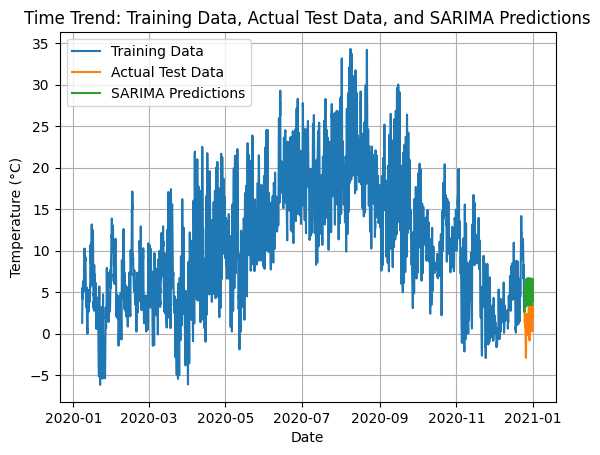

In [ ]:
sarima_pred_series = pd.Series(sarima_pred, index=test_df.index)

plt.plot(train_df.index, train_df['T'], label='Training Data')
plt.plot(test_df.index, test_df['T'], label='Actual Test Data')
plt.plot(sarima_pred_series.index, sarima_pred_series, label='SARIMA Predictions')
plt.title('Time Trend: Training Data, Actual Test Data, and SARIMA Predictions')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#fit the full sarima model and make a full day forecast
sarima_full_model = sm.tsa.SARIMAX(
    df['T'],
    order=(2,0,2),
    seasonal_order=(1,0,1,24),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_full_res = sarima_full_model.fit(disp=False)
sarima_full_pred = sarima_full_res.get_forecast(steps=24).predicted_mean
print("SARIMA model trained on full dataset and 24-step forecast generated.")

SARIMA model trained on full dataset and 24-step forecast generated.


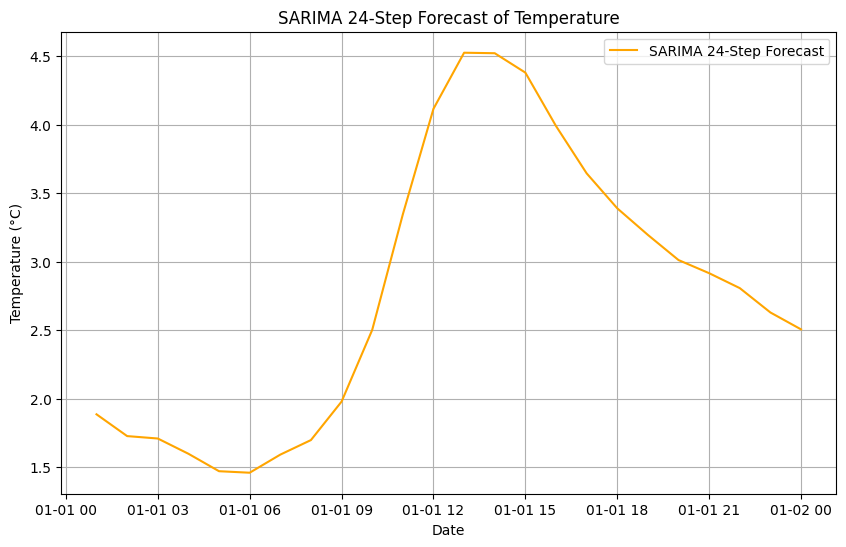

In [ ]:
last_timestamp_full = df.index[-1]
future_index_full = pd.date_range(start=last_timestamp_full + pd.Timedelta(hours=1), periods=24, freq='h')

plt.figure(figsize=(10, 6))
plt.plot(future_index_full, sarima_full_pred, label='SARIMA 24-Step Forecast', color='orange')
plt.title('SARIMA 24-Step Forecast of Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

### Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
def create_lag_features(df, target_col, n_lags=24):
    data = df.copy()
    for lag in range(1, n_lags + 1):
        data[f"lag_{lag}"] = data[target_col].shift(lag)
    data = data.dropna()
    return data

In [ ]:
lagged = create_lag_features(df, "T", n_lags=24)

#train-test split
split_idx = int(len(lagged) * 0.8)
train = lagged.iloc[:split_idx]
test  = lagged.iloc[split_idx:]

X_train = train.drop("T", axis=1)
y_train = train["T"]

X_test = test.drop("T", axis=1)
y_test = test["T"]

In [ ]:
#train the randomforest regressor
model_rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)
model_rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300, random_state=42)

In [ ]:
#make predictions and evaluate the random forest performance on test data
rf_pred = model_rf.predict(X_test)

rf_mae  = mae(y_test, rf_pred)
rf_rmse = rmse(y_test, rf_pred)

print("Random Forest Forecasting Evaluation:")
print(f"MAE : {rf_mae:.4f}")
print(f"RMSE: {rf_rmse:.4f}")

Random Forest Forecasting Evaluation:
MAE : 0.0071
RMSE: 0.0108


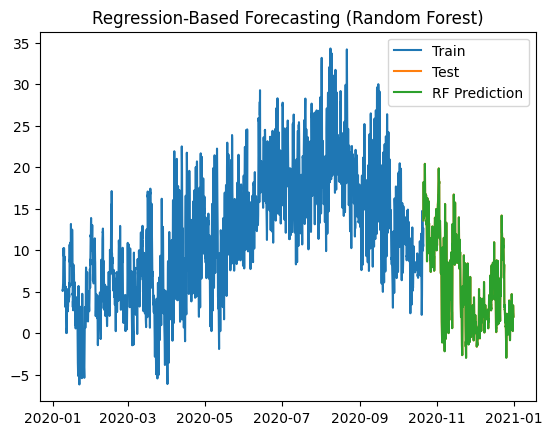

In [ ]:
plt.plot(train.index, y_train, label="Train")
plt.plot(test.index, y_test, label="Test")
plt.plot(test.index, rf_pred, label="RF Prediction")
plt.title("Regression-Based Forecasting (Random Forest)")
plt.legend()
plt.show()

In [ ]:
#making a full day forecast with random forest
full_data = create_lag_features(df, "T", n_lags=24)
X_full = full_data.drop("T", axis=1)
y_full = full_data["T"]

model_rf.fit(X_full, y_full)
future_steps = 24

#get the last row of features as a Series
last_row = X_full.iloc[-1]
future_forecasts = []
current_lags = list(last_row.values)

for _ in range(future_steps):
    pred_input = pd.DataFrame([current_lags], columns=X_full.columns)
    next_pred = model_rf.predict(pred_input)[0]
    future_forecasts.append(next_pred)
    current_lags = [next_pred] + current_lags[:-1]

print("\nNext 24-steps forecasts:")
print(future_forecasts)



Next 24-steps forecasts:
[np.float64(2.007155555555551), np.float64(33.61352777777775), np.float64(-5.80952222222222), np.float64(32.59394999999997), np.float64(32.289416666666654), np.float64(-5.814766666666661), np.float64(25.962599999999966), np.float64(-5.818322222222221), np.float64(25.43790555555551), np.float64(25.29933333333331), np.float64(-5.824538888888887), np.float64(21.66443333333333), np.float64(-5.870244444444441), np.float64(21.34210555555562), np.float64(21.25426111111112), np.float64(-5.825544444444444), np.float64(18.733116666666614), np.float64(-5.817672222222223), np.float64(18.500099999999996), np.float64(18.442122222222224), np.float64(-5.846083333333331), np.float64(16.44090555555556), np.float64(-5.8250777777777785), np.float64(16.244272222222197)]


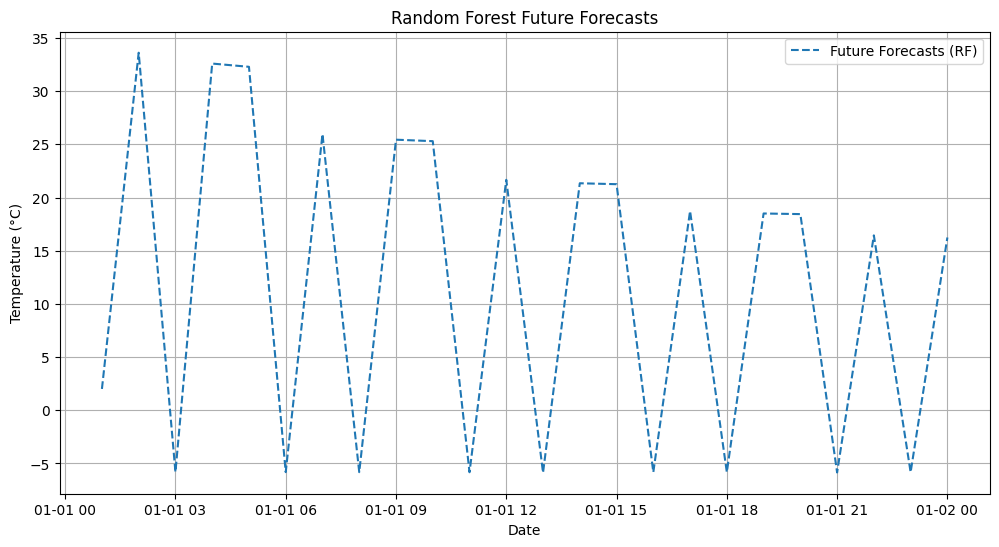

In [ ]:
#plotting the forecast made with random forest
last_timestamp = y_full.index[-1]
future_index = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=future_steps, freq='h')

plt.figure(figsize=(12, 6))
plt.plot(future_index, future_forecasts, label='Future Forecasts (RF)', linestyle='--')
plt.title('Random Forest Future Forecasts')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

### LSTM

In [ ]:
from sklearn.preprocessing import MinMaxScaler
data = df[["T"]].copy()

scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

#convert the data to sequences
def create_sequences(data, seq_len=24):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [ ]:
#creating the sequences for lstm
seq_len = 24
X, y = create_sequences(scaled, seq_len)

#train-test split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

#reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0],  X_test.shape[1],  1))


In [ ]:
#initiate and train the lstm model
model = Sequential()
model.add(LSTM(50, activation='tanh', return_sequences=False, input_shape=(seq_len, 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0247
Epoch 2/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0020
Epoch 3/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013
Epoch 4/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0010
Epoch 5/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.6371e-04
Epoch 6/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.1781e-04
Epoch 7/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.1214e-04
Epoch 8/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 5.3904e-04
Epoch 9/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.8781e-04
Epoch 10/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.5014e-04
Epoch 11/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.2177e-04
Epoch 12/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.9966e-04
Epoch 13/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.8148e-04
Epoch 14/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.6592e-04
Epoch 15/20
215

In [ ]:
lstm_scaled_pred = model.predict(X_test).ravel()

#inverse scaling
lstm_pred = []
for i, p in enumerate(lstm_scaled_pred):
    row = X_test[i, -1, :].copy()
    row[0] = p
    inv = scaler.inverse_transform(row.reshape(1,-1))[0,0]
    lstm_pred.append(inv)

lstm_pred = np.array(lstm_pred)


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [ ]:
lstm_mae = mae(y_test, lstm_pred)
lstm_rmse = rmse(y_test, lstm_pred)
print("LSTM MODEL")
print("MAE :", lstm_mae)
print("RMSE:", lstm_rmse)

LSTM MODEL
MAE : 5.833804384215152
RMSE: 7.486848368010018


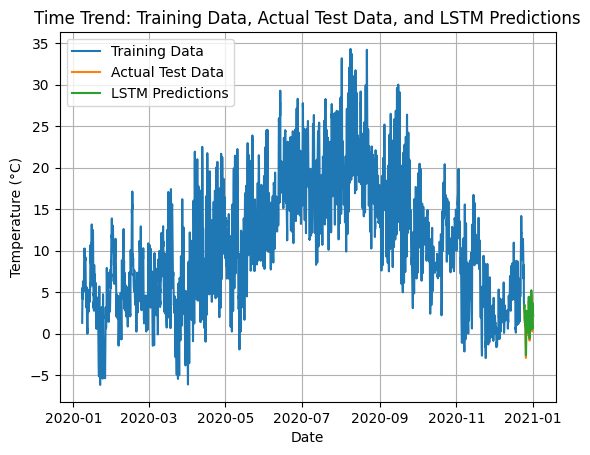

In [ ]:
#create a pandas Series for LSTM predictions with the correct time index
lstm_pred_series = pd.Series(lstm_pred, index=df.index[len(df) - len(y_test):])

#filter LSTM predictions to match the time range of test_df
lstm_pred_for_plot = lstm_pred_series.loc[test_df.index.min():test_df.index.max()]

#plotting
plt.plot(train_df.index, train_df['T'], label='Training Data')
plt.plot(test_df.index, test_df['T'], label='Actual Test Data')
plt.plot(lstm_pred_for_plot.index, lstm_pred_for_plot, label='LSTM Predictions')
plt.title('Time Trend: Training Data, Actual Test Data, and LSTM Predictions')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#prepare the full data to train lstm for future forecast
X_full_lstm, y_full_lstm = create_sequences(scaled, seq_len)

X_full_lstm = X_full_lstm.reshape((X_full_lstm.shape[0], X_full_lstm.shape[1], 1))

model_full = Sequential()
model_full.add(LSTM(50, activation='tanh', return_sequences=False, input_shape=(seq_len, 1)))
model_full.add(Dense(1))

model_full.compile(optimizer='adam', loss='mse')

history_full = model_full.fit(X_full_lstm, y_full_lstm, epochs=20, batch_size=32, verbose=0)

#prepare initial input for forecasting using the last sequence from the full dataset
last_sequence = scaled[-seq_len:]
current_input_sequence = last_sequence.reshape((1, seq_len, 1))

lstm_full_forecast_scaled = []
future_steps = 24

for _ in range(future_steps):
    #predict the next value
    next_pred_scaled = model_full.predict(current_input_sequence)[0, 0]
    lstm_full_forecast_scaled.append(next_pred_scaled)

    #update the input sequence
    new_sequence = np.append(current_input_sequence[:, 1:, :], [[[next_pred_scaled]]], axis=1)
    current_input_sequence = new_sequence

#inverse transform the scaled predictions
lstm_full_forecast = scaler.inverse_transform(np.array(lstm_full_forecast_scaled).reshape(-1, 1)).flatten()

print("LSTM model retrained on full dataset and 24-step forecast generated.")
print("Future 24-step forecast:")
print(lstm_full_forecast)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
LSTM model retrained on full dataset and 24-step forecast generated.
Future 24-step for

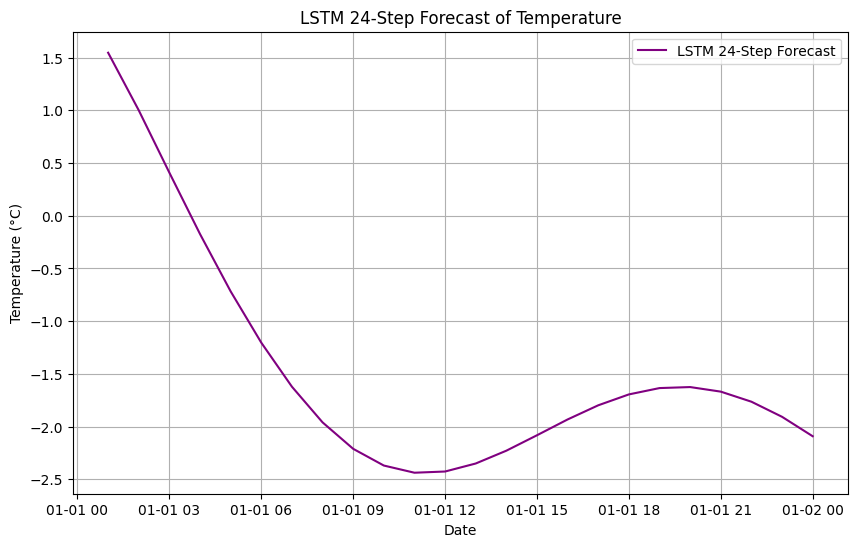

In [ ]:
#plotting the full day forecast made with lstm
last_timestamp_full = df.index[-1]
future_index_lstm = pd.date_range(start=last_timestamp_full + pd.Timedelta(hours=1), periods=future_steps, freq='h')

plt.figure(figsize=(10, 6))
plt.plot(future_index_lstm, lstm_full_forecast, label='LSTM 24-Step Forecast', color='purple')
plt.title('LSTM 24-Step Forecast of Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

**Computing the results from the evaluation of all the models**

In [ ]:
results = pd.DataFrame({
    'Model': ['Naive', 'Seasonal Naive', 'Mean', 'SARIMA', 'Random Forest', 'LSTM'],
    'MAE': [naive_mae, seasonal_mae, mean_model_mae, sarima_mae, rf_mae, lstm_mae],
    'RMSE': [naive_rmse, seasonal_rmse, mean_model_rmse, sarima_rmse, rf_rmse, lstm_rmse]
})

print("\nModel Evaluation Results")
results



Model Evaluation Results


,Model,MAE,RMSE
0,Naive,1.636796,2.031545
1,Seasonal Naive,4.750933,5.840902
2,Mean,9.717504,9.825716
3,SARIMA,3.022508,3.277767
4,Random Forest,0.007115,0.010846
5,LSTM,5.833804,7.486848


The forecasting results show clear performance differences across the tested models. Baseline methods provided simple reference points, with the Naive model performing better than the Mean and Seasonal-Naive approaches. SARIMA captured daily seasonal structure reasonably well but did not achieve the lowest errors. Random Forest delivered the best overall performance, reaching an MAE of 0.007 and an RMSE of 0.011 after using lagged features and tree-based regression. LSTM underperformed in this case, suggesting that the dataset size, noise patterns, or model configuration limited its effectiveness. Overall, the results indicate that a well-designed machine learning model can outperform both classical statistical methods and deep learning for short-term hourly temperature forecasting on this dataset.